# Automating QUBO Conversion

In [1]:
# !pip install numpy
# !pip install cplex
# !pip install qiskit-optimization

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from PuboOnGraph import Graph,listLidar,listCovering

G = nx.Graph()

points1 = [] #placement of lidars for one side
points2 = [] #placement of lidars for other side
points3 = [] #vertices to cover

pointsL = listLidar
points3 = listCovering
G = Graph

#G.add_nodes_from(points1 + points2 + points3)

def showGraph(S):
    
    pos = {node: node for node in G.nodes()} 
    nx.draw(G, pos, with_labels=False, node_size=40)
    actE = []
    actN = []
    for node in S:
      for edge in G.edges(node):
        actE.append(edge)
      for node2 in G.neighbors(node):
        actN.append(node2)
    # Draw the graph
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, with_labels=False,node_color = 'grey', node_size=40)
    nx.draw_networkx_nodes(G, pos, listLidar, node_color = 'purple', node_size= 40)
    nx.draw_networkx_nodes(G, pos, S, node_color='red', node_size=40)
    nx.draw_networkx_nodes(G, pos, actN, node_color='blue', node_size=40)
    nx.draw_networkx_nodes(G, pos, S, node_color='red', node_size=40)
    nx.draw_networkx_edges(G, pos, actE, edge_color='red', node_size=40)
    plt.show()

// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[59];
dvar bool y[351];

minimize
 x_m9.681336353374148_18.978743095907507
 + x_m9.918470838622282_16.844532728674295
 + x_m10.155605323870418_14.710322361441083
 + x_m10.392739809118552_12.576111994207869
 + x_m10.629874294366687_10.441901626974657
 + x_m10.867008779614821_8.307691259741445
 + x_m11.104143264862957_6.1734808925082305
 + x_m11.341277750111091_4.039270525275018
 + x_m11.578412235359226_1.905060158041806
 + x_m11.815546720607362_m0.22915020919140616
 + x_m12.052681205855496_m2.3633605764246184
 + x_m6.318663646625852_13.021256904092493
 + x_m6.550583757004272_10.93397591068672
 + x_m6.782503867382691_8.846694917280946
 + x_m7.01442397776111_6.7594139238751705
 + x_m7.24634408813953_4.672132930469397
 + x_m7.47826419851795_2.5848519370636236
 + x_m7.7487801976466475_18.086794100956354
 + x_m5.816224041919148_17.1948451060052
 + x_m3.883667886191649_16.302896111054046
 + x

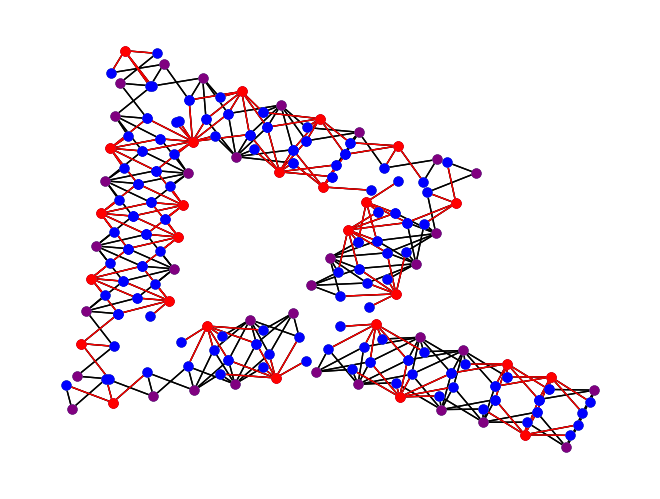

In [3]:
import os
from platform import node
import numpy as np
import qiskit_optimization
from docplex.mp.model import Model
from qiskit_optimization.problems import QuadraticProgram
import networkx as nx

m = Model(name='BMW')
x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'

y = m.binary_var_dict(G.edges, name='y')

#constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
for node in points3:
  var =[]
  for i in G.edges(node):
    if i in y:
      var.append(y[i])
    elif (i[1], i[0]) in y:
      var.append(y[i[1],i[0]])
  m.add_constraint(sum(var) >= 1)

#Link the relation between edge activation and lidar placement activation

for node in pointsL:
  var =[]
  for i in G.edges(node):
    if i[0] == node:
      if i in y:
        var.append(y[i]- x[node])
      elif (i[1], i[0]) in y:
        var.append(y[i[1],i[0]]- x[node])
    m.add_constraint(sum(var) == 0)

print(m.prettyprint())
m.export_as_lp(basename="BMW", path=os.path.abspath(""))

sol_model = m.solve()
m.print_solution()

S = []
for (x, y) in sol_model.iter_var_values():
    sx = str(x)
    if sx[0] == 'x':
        var =sx.split("_")
        S.append((float(var[1]), float(var[2])))
showGraph(S)

In [4]:
quadratic_program = QuadraticProgram()
quadratic_program.read_from_lp_file(os.path.join(os.path.abspath(""), 'BMW.lp'))
print(quadratic_program.prettyprint())
#6 binary variables
#14 integer variables

Problem name: BMW

Minimize
  x_0.1365823022135224_10.04191262001278
  + x_0.46846321214597264_5.409062379291525
  + x_1.3783970819863105_7.2289301189722
  + x_1.8732339247321312_m2.903359492746654
  + x_1.9140005809908498_13.627049126200586
  + x_10.129223739771906_m6.205755418762564
  + x_11.415493384840664_m2.4121314310824644
  + x_12.193221193531848_m7.03135440026654
  + x_13.579137368774436_m3.277589024655973
  + x_2.2883309518266484_9.048797858652875
  + x_2.7609174491055755_1.049698943211571
  + x_3.7510677689191305_3.0299995828386814
  + x_3.84655673671835_12.735100131249432
  + x_3.9372313784920747_m3.728958474250631
  + x_4.741218088732686_5.010300222465792
  + x_4.924561433039347_0.18424134963806227
  + x_5.731368408546241_6.9906008620929025
  + x_5.77911289244585_11.843151136298278
  + x_6.001228832252018_m4.554557455754608
  + x_6.721518728359797_8.970901501720014
  + x_7.0882054169731195_m0.6812162439354466
  + x_7.711669048173352_10.951202141347125
  + x_8.06522628601196

In [5]:
from qiskit_optimization.converters import QuadraticProgramToQubo
import math
#le qubo

conv = QuadraticProgramToQubo()
qp = conv.convert(quadratic_program)
#print(qp.get_num_binary_vars)
#print(qp.prettyprint())
#Binary variables = 138
# le qubo
# print(qp.objective.linear.to_array())
# print(qp.objective.linear.coefficients)
# print(qp.objective.quadratic.to_array())
# print(qp.objective.quadratic.coefficients)
matrice = qp.objective.quadratic.coefficients.asformat("array")
diagonal = qp.objective.linear.coefficients.asformat("array")
num = 0
num1 = 0
for i in range (len(matrice)):
    num1 = 0
    for j in range(len(matrice[i])):
        num1 += 1
        if j == i:
            matrice[i][j] += diagonal[0][j]
    num += 1
matrice2 = np.zeros((int(math.sqrt(len(matrice))+1)**2,int(math.sqrt(len(matrice))+1)**2))
matrice2[:len(matrice),:len(matrice)] = matrice


# print(num, num1)
    # print("diagonal = ",diagonal[0][i])
print(type(matrice))
np.save("matrice_QUBO_RR.npy",matrice2)
# print(qp.objective.constant)
# print(qp.objective.quadratic)
# print(qp.binary_var_list(78)[0].as_tuple())
# for n in qp.integer_var_dict(60).items():
#     print(n[1].name)
# print(qp.integer_var_dict)
#print(qp.prettyprint())

# def extract_qubo_coefficients(qp: QuadraticProgram) -> np.ndarray:
#     num_variables = qp.get_num_vars()
#     qubo_matrix = np.zeros((num_variables, num_variables))

#     for i in range(num_variables):
#         # Coefficient of linear term
#         # qubo_matrix[i, i] = 
#         print("qp.get_variable(",i,")",qp.get_variable(i))
#         print("qp.get_variable(",i,")",qp.objective.linear)
#         # qp.get_linear_coefficient
#         # (qp.get_variable(i))

#         # Coefficients of quadratic terms
#         for j in range(i + 1, num_variables):
#             print("qp.get_variable(",i,")",qp.get_variable(i), "qp.get_variable(",j,")",qp.get_variable(j))
#             # qubo_matrix[i, j] = qp.objective.linear.coefficients(qp.get_variable(i), qp.get_variable(j))
#             # qubo_matrix[j, i] = qubo_matrix[i, j]  # QUBO matrix is symmetric
#     return qubo_matrix

# # Assuming you have a QuadraticProgram named 'quadratic_program'
# qubo_matrix = extract_qubo_coefficients(quadratic_program)
# print(qubo_matrix)
# print(qp.prettyprint())
# #Binary variables = 78

<class 'numpy.ndarray'>


NetworkXError: Node (-9.681336353374148, 18.978743095907507) has no position.

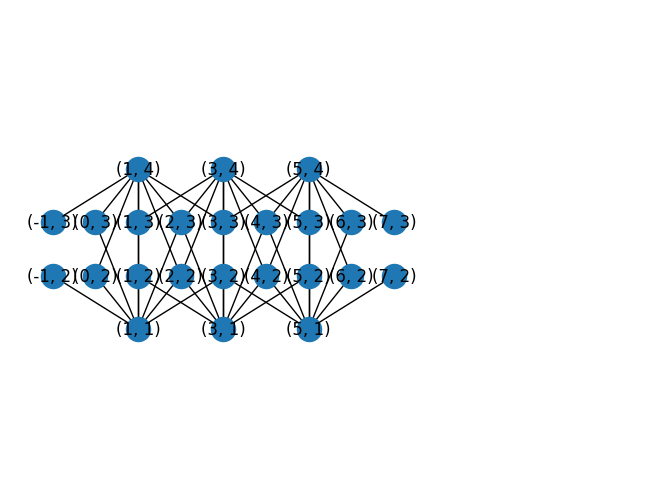

In [6]:

G = nx.Graph()


points1 = [] #placement of lidars for one side
points2 = [] #placement of lidars for other side
points3 = [] #vertices to cover


for i in range(1, 6, 2):
    point = (i, 1)
    points1.append(point)

for i in range(1, 6, 2):
    point = (i, 4)
    points2.append(point)

for i in range(0, 7):
    for j in range(2, 4):
        point = (i, j)
        points3.append(point)

G.add_nodes_from(points1 + points2 + points3)


#edge that represents scope between lidar placement and vertices to cover
for node1 in points1:
  for j in range (node1[1]+1, node1[1]+3):
    if(j==node1[1]+1):
      for i in range(node1[0]-2, node1[0]+3):
        G.add_edge(tuple(node1), (i,j))
    if(j== node1[1]+2):
      for i in range(node1[0]-1, node1[0]+2):
        G.add_edge(tuple(node1), (i,j))
for node2 in points2:
  for j in range (node2[1]-2,node2[1]):
    if(j== node2[1]-2):
      for i in range(node2[0]-1, node2[0]+2):
        G.add_edge(tuple(node2), (i,j))
    if(j==node2[1]-1):
      for i in range(node2[0]-2, node2[0]+3):
        G.add_edge(tuple(node2), (i,j))
actE =[]
for node in S:
  for edge in G.edges(node):
    actE.append(edge)
# Draw the graph
pos = {node: node for node in G.nodes()}
nx.draw(G, pos, with_labels=True)

plt.xlim(-2, 13)
plt.ylim(-2, 7)

plt.xticks(range(1, 13))
plt.yticks(range(1, 7))
nx.draw_networkx_nodes(G, pos, S, node_color='red')
nx.draw_networkx_edges(G, pos, actE, edge_color='red')
plt.show()

In [ ]:
# #PREMIER TEST
# import os
# from platform import node
# import numpy as np
# import qiskit_optimization
# from docplex.mp.model import Model
# from qiskit_optimization.problems import QuadraticProgram
# import networkx as nx

# m = Model(name='BMW')
# pointsL = points1 + points2
# x = m.binary_var_dict(pointsL, name='x')
# m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
# m.objective_sense = 'min'

# #constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
# for node in points3:
#   y = m.binary_var_dict(G.edges(node), name='y')
#   degre = len(y)
#   print(len(y))
#   m.add_constraint(sum(y[i] for i in G.edges(node)) <= degre)
#   m.add_constraint(sum(y[i] for i in G.edges(node)) >= 1)

# print(m.prettyprint())
# m.export_as_lp(basename="BMW", path=os.path.abspath(""))

# #Link the relation between edge activation and lidar placement activation
# for node in pointsL:
#  invEdges = [(i[1], i[0]) for i in G.edges(node)]#need to link the same edge from constraint 2 and the lidars placement
#  y = m.binary_var_dict(invEdges, name='y')
#  m.add_constraint(sum(y[i] - x[node] for i in invEdges if i[1] == node) == 0)